In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm
from catboost import Pool
from catboost import CatBoostRegressor

C:\Users\kaihu\Anaconda2\envs\py3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:

train = pd.read_csv('d_train_20180102.csv',encoding='gbk')
test_A = pd.read_csv('d_test_A_20180102.csv',encoding='gbk')
test_B = pd.read_csv('d_test_B_20180128.csv',encoding='gbk')

print('train shape',train.shape)
print('test shape',test_B.shape)

train shape (5642, 42)
test shape (1000, 41)


In [6]:
# *天门冬氨酸氨基转换酶 和 *丙氨酸氨基转换酶 相关性高，同时后者对血糖相关性要高于前者，故删除前者
# 同理 低密度脂蛋白胆固醇>总胆固醇
# 血红蛋白>红细胞计数、红细胞压积 以后可考虑用综合指标
#drop_list = ['*天门冬氨酸氨基转换酶','总胆固醇','id','*总蛋白','白球比例','红细胞压积','红细胞计数',
            #'红细胞平均体积','血小板比积','淋巴细胞%','体检日期']
drop_list = ['体检日期','id']
train.drop(drop_list,inplace=True,axis=1)
test_A.drop(drop_list,inplace=True,axis=1)
test_B.drop(drop_list,inplace=True,axis=1)

sex_map = {'男':1,'女':0,'??':0}
x = train.drop(['血糖'],axis=1)
x['性别'] = x['性别'].map(sex_map)
test_A['性别'] = test_A['性别'].map(sex_map)
test_B['性别'] = test_B['性别'].map(sex_map)


In [7]:
cat_features_ids = np.where(x.apply(pd.Series.nunique) < 3)[0].tolist()
#cat_features_ids = np.array([0,1])

In [8]:
data = pd.concat([x,test_A,test_B],axis=0)

In [9]:
# 连续属性转类别属性
def age_to_cate(age):
    if age<20:
        return 0
    elif age<30:
        return 1
    elif age<40: 
        return 2
    elif age<50:
        return 3
    elif age<60:
        return 4
    elif age<70:
        return 5
    else:
        return 6
data['年龄'] = data['年龄'].apply(lambda x:age_to_cate(x))

In [10]:
for j in tqdm(range(2,len(data.columns))):
    for i in range(len(data)):
        if pd.isnull(data.iloc[i,j]):
            data.iloc[i,j] = data[(data.年龄==data.iloc[i,1])&(data.性别==data.iloc[i,0])].iloc[:,j].mean()
            if pd.isnull(data.iloc[i,j]):
                #print(i,j)
                data.iloc[i,j] = data.iloc[:,j].mean()
            # print(x.iloc[i,j])

In [12]:
import copy
testdata = copy.deepcopy(data)

In [13]:
data.iloc[:,2:] = testdata.iloc[:,2:].apply(lambda x: x.clip_upper(np.percentile(x,99)))

In [30]:
t = len(x)+len(test_A)
x = data.iloc[0:t,:]
test_B = data.iloc[t:,:]

In [74]:
answer_test_A = pd.read_csv('d_answer_a_20180128.csv',encoding='gbk',header=None)
y = train['血糖']

print(len(answer_test_A))

1000


In [38]:
#x.fillna(x.mean(),inplace=True)

In [37]:
#x.drop(['乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体'],axis=1,inplace=True)
x = x.values

In [77]:
temp = pd.concat([y,answer_test_A],axis=0)
y = temp.reset_index(drop=True)

In [80]:
y = y.iloc[:,0]

In [81]:
type(y)

pandas.core.series.Series

In [89]:
clf = CatBoostRegressor(learning_rate=0.01, iterations=2500, random_seed=0,logging_level='Silent')
#clf.fit(train_df, labels, cat_features=cat_features_ids)

In [90]:
kfolds = 5
result = np.zeros((kfolds,len(test_B)))
kf = KFold(n_splits=kfolds,shuffle=False)
i = 0
predict_y = []
real_y = []
score = []
for train_index,test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    y_train=y_train.clip_upper(15)
    train_pool = Pool(X_train, y_train,cat_features=cat_features_ids)
    eval_pool = Pool(X_test, y_test,cat_features=cat_features_ids)
    clf.fit(train_pool)
    #clf.fit(train_pool,use_best_model=True,eval_set=eval_pool)
    print(clf.score(X_test, y_test))
    predict_y.append(clf.predict(X_test))
    real_y.append(y_test)
    score.append(clf.score(X_test, y_test)**2/2)
    real_test =  Pool(test_B,cat_features=cat_features_ids)
    result[i,:]=clf.predict(real_test)
    i+=1
print('平均误差%f'%(np.mean(score)))
# best model 0.9773

1.14075273337
1.38311521719
1.32639394854
1.67989318555
1.34428527934
平均误差0.960279


In [112]:
kfolds = 10
result = np.zeros((kfolds,len(test)))
kf = KFold(n_splits=kfolds,shuffle=True,random_state=2016)
i = 0
predict_y = []
real_y = []
score = []
for train_index,test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    y_train=y_train.clip_upper(15)
    train_pool = Pool(X_train, y_train,cat_features=cat_features_ids)
    eval_pool = Pool(X_test, y_test,cat_features=cat_features_ids)
    clf.fit(train_pool,use_best_model=True,eval_set=eval_pool)
    print(clf.score(X_test, y_test))
    predict_y.append(clf.predict(X_test))
    real_y.append(y_test)
    score.append(clf.score(X_test, y_test)**2/2)
    real_test =  Pool(test,cat_features=cat_features_ids)
    result[i,:]=clf.predict(real_test)
    i+=1
print('平均误差%f'%(np.mean(score)))
# best model 0.9773

1.26174246636
1.98342505716
1.34940142637
1.28350858877
1.53674675145
1.35780794146
1.27827268441
1.36763113055
1.17659275367
1.16567958399
平均误差0.972353


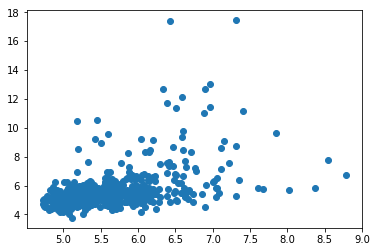

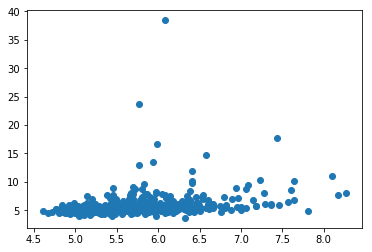

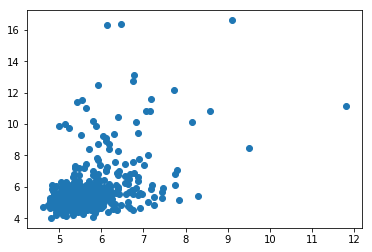

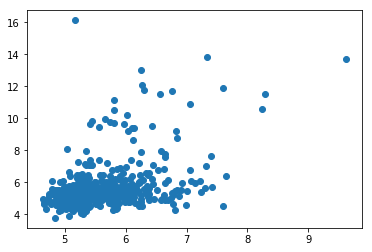

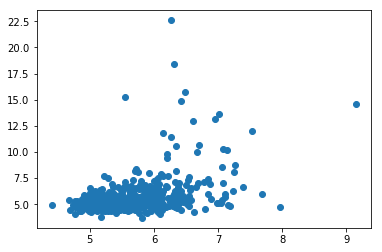

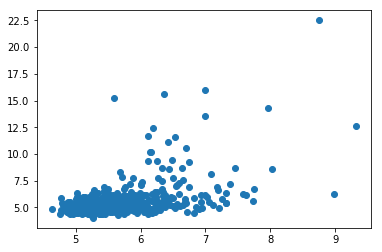

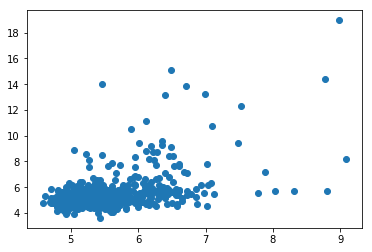

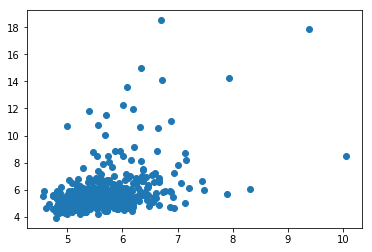

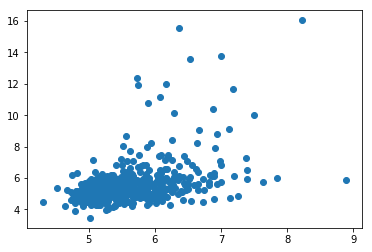

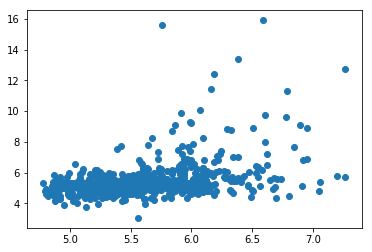

In [113]:
import matplotlib.pyplot as plt
for i in range(kfolds):
    fig = plt.figure()
    plt.scatter(predict_y[i],real_y[i])
    plt.show()

5642


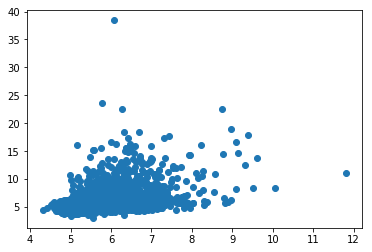

In [114]:
# 5个验证集上预测值与实际值得对比
x_cut = []
y_cut = []
for i in range(kfolds):
    x_cut.extend(predict_y[i])
    y_cut.extend(real_y[i])
print(len(x_cut))
plt.scatter(x_cut,y_cut)
plt.show()

C:\Users\kaihu\Anaconda2\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kaihu\Anaconda2\envs\py3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


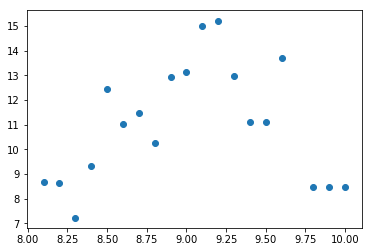

In [115]:
fit_data = sorted(list(zip(x_cut,y_cut)),key=lambda x:x[0])
left = 8
right = left
ave_y = []
ave_x = []
while left <10:
    left = left+0.1
    right = left+0.3
    temp = []
    for j in fit_data:
        if left<= j[0]<=right:
            temp.append(j[1])
    ave_x.append(left)
    ave_y.append(np.mean(temp))
plt.scatter(ave_x,ave_y)
plt.show()


In [116]:
from sklearn.linear_model import LinearRegression as lr
clf = lr()
clf.fit([[k] for k in ave_x[0:13]],ave_y[0:13])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [120]:
clf.predict([[9]])

array([ 13.08533288])

In [83]:
submit = result.mean(axis=0)
#submit = [x if x<=8 else clf.predict([[x]])[0] for x in submit]
submit_file = pd.DataFrame(submit)
submit_file.to_csv('diabetes_0128.csv',index=False,header=False)